In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.optimizers import Nadam, Adam
import matplotlib.pyplot as plt

import numpy as np

#TODO: OPTIMISE. This NN learns first mode oscillations, but slowly. We need it to be faster if we want to train for both more masses and over larger time intervals. 

#Optimise tensorflow linear algebra
tf.config.optimizer.set_jit(True)

#Number of masses
n_degrees = 3

"""
Simple NN. TODO: I went a bit overboard with the architecture. Investigate how the size of the NN actually makes a difference? 
#People don't use anything too crazy in literature.
"""
model = Sequential([
    Dense(256, input_dim=1, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(n_degrees)
])

#Alternative model. Similar to paper.
"""input_layer = Input(shape=(1,))
split_1 = [Dense(32, activation='tanh')(input_layer) for i in range(n_degrees)]
split_2 = [Dense(32, activation='tanh')(split_1[i]) for i in range(n_degrees)]
output_layer = [Dense(1, activation='tanh')(split_2[i]) for i in range(n_degrees)]
model = Model(inputs=input_layer,outputs = output_layer)"""

opt = Adam(learning_rate=0.001)

#Evaluate x, dx/dt, d2x/dt2 for model over time array.
@tf.function
def eval_model(t, model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(t)
            x = tf.concat(model(t, training=True),axis=1)
            dx = tf.concat([tape2.gradient(x[:,i],t) for i in range(n_degrees)],axis=1)
        dx2 = tf.concat([tape.gradient(dx[:,i],t) for i in range(n_degrees)],axis=1)
    return x, dx, dx2

#PINN ODE loss (current implementation for linear system of springs)
def ode_loss(t, x, dx, dx2):
    total_ode = []
    for i in range(0,n_degrees):
        if(i==0):
            total_ode.append(tf.reduce_mean(tf.square(dx2[:,i]+2*x[:,i]-x[:,i+1])))
        elif(i==n_degrees-1):
            total_ode.append(tf.reduce_mean(tf.square(dx2[:,i]+2*x[:,i]-x[:,i-1])))
        else:
            total_ode.append(tf.reduce_mean(tf.square(dx2[:,i]+2*x[:,i]-x[:,i-1]-x[:,i+1])))
    return tf.reduce_mean(total_ode)

#PINN Initial condition loss. (Currently 1st mode initial conditions passed into the function)
def ic_loss(x, dx, x0, dx0,include_dx=True):
    return tf.reduce_mean(tf.square(x-x0)) + include_dx * tf.reduce_mean(tf.square(dx-dx0))

#Define number of iterations
n_epochs = 4096

#Define a time lattice to train on.
resolution = 8192
max_time = 5

time = tf.constant(np.sort(np.random.rand(resolution) * max_time).reshape(-1,1),dtype=tf.float32)

#Training loop. Optimised as a tf.function
@tf.function
def training_loop(time):
    with tf.GradientTape() as tape:
        x, dx, dx2 = eval_model(time, model)
        loss = ode_loss(time,x,dx,dx2) + ic_loss(x[0,:],dx[0,:],np.sin(np.arange(1,n_degrees+1)*np.pi/(n_degrees+1)),[0],include_dx=False)
        #Log loss. Loss should go to around 1e-5 or 1e-6 when it works fairly quickly and continue to converge. Plateaus at around e-1 for multivariate ODEs. TODO: Fix.
    grad = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad,model.trainable_variables))
    return loss
#Custom training loop using PINN loss.
for e in range(n_epochs):
    loss = training_loop(time)
    print(loss)


2024-06-04 13:44:32.589799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 13:44:32.828324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 13:44:32.829893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 13:44:35.041158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tf.Tensor(0.8863997, shape=(), dtype=float32)
tf.Tensor(17.354465, shape=(), dtype=float32)


: 

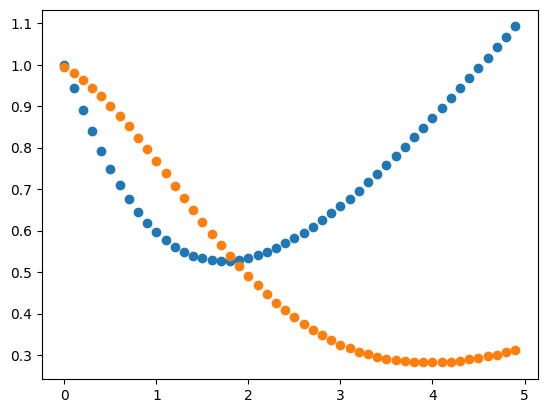

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim

#Ignore the graph below.

#Evaluate model over discrete time array.
testtime = np.arange(0,max_time,0.1).reshape(-1,1)
x = tf.concat(model(testtime),axis=1)

#Code for rendering animations of multivariate ODEs over time.
fig, ax = plt.subplots()

def animate(i):
        ax.clear()
        ax.set_ylim(bottom=-2,top=2)
        ax.plot(x[i,:])
        return ax

animator = anim.FuncAnimation(fig, animate, frames=len(testtime),interval=100)
animator.save("preview.mp4",writer='ffmpeg')